In [2]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone --single-branch https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 180 (delta 78), reused 134 (delta 49), pack-reused 0
Receiving objects: 100% (180/180), 28.64 MiB | 30.05 MiB/s, done.
Resolving deltas: 100% (78/78), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=15097 sha256=54bed2676717dba5ac3aa3100be1c7cd0cc0b44ebecc1bf1b3fb80cb1db7dabf
  Stored in directory: /tmp/pip-ephem-wheel-cache-z8vrqy7i/wheels/55/59/29/0fb1c63565215773

In [3]:
from dul_2021.utils.hw3_utils import *


# Question 1: Autoregressive Flows for Images

Adapt your PixelCNN implementation from Homework 2 and use it as an autoregressive flow model on the black-and-white shapes dataset. Using the base architecture from Homework 2 1(a), output a mixture of logistics or gaussians (instead of logits), whose CDF we will use as our flow for each dimension of x. 

Remember: you must dequantize the data and scale it between 0 and 1 for the autoregressive flow to have stable training. 

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. **Make sure to account for any rescaling you do in your nats/dim.**
2.   Report the final test set performance of your final model
3. 100 samples from your autoregressive flow. Our plotting code will show your samples, with and without clipping and flooring (to remove the quantization). 


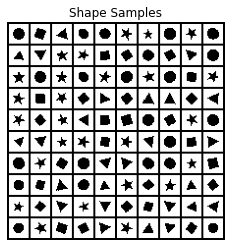

In [4]:
visualize_q1_data()

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [41]:
import torch
from torch.utils.data import DataLoader
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
import torch.nn as nn
from tqdm import tqdm
from scipy.optimize import bisect

In [102]:
device = 'cuda'

def test(model, testloader):
    with torch.no_grad():
        total_loss = 0
        tc = 0
        for batch in testloader:
            loss = model.nll(batch.to(device).float()).item()
            total_loss += loss * batch.shape[0]
            tc += batch.shape[0]
        return total_loss / tc

def train(model, train_data, test_data, num_epochs=20, lr=1e-3, batch_size=128):

    trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(test_data, batch_size=batch_size)
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    train_loss = []
    test_loss = []
    test_loss.append(test(model, testloader))
    
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        model.train()
        for batch in trainloader:
            batch = batch.to(device).float()
            batch = (batch + torch.rand_like(batch)) * 0.5
            loss = model.nll(batch)
            
            optim.zero_grad()
            loss.backward()
            optim.step()

            train_loss.append(loss.item())
        pbar.set_postfix({'train_loss': loss.item()})

        model.eval()
        loss_test = test(model, testloader)
        test_loss.append(loss_test)
    
    return np.array(train_loss) + np.log(2), np.array(test_loss) + np.log(2)

In [103]:
class MaskedConv(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.set_mask()
    
    def forward(self, x):
        # self.weight.data *= mask
        return F.conv2d(x, self.mask * self.weight, bias=self.bias, stride=self.stride, padding=self.padding)

    def set_mask(self):
        raise NotImplementedError()

class ConvA(MaskedConv):
    def set_mask(self):
        h, w = self.kernel_size
        self.mask[:, :, h // 2, : w // 2] = 1
        self.mask[:, :, :h // 2] = 1
    
class ConvB(MaskedConv):
    def set_mask(self):
        h, w = self.kernel_size
        self.mask[:, :, h // 2, : w // 2 + 1] = 1
        self.mask[:, :, :h // 2] = 1

class ResBlock(nn.Module):
    def __init__(self, in_c, use_norm=True):
        super().__init__()
        layers = [nn.ReLU(),
                  ConvB(in_c, in_c // 2, kernel_size=(1, 1), stride=1, padding=0),
                  nn.ReLU(), 
                  ConvB(in_c // 2, in_c // 2, kernel_size=(7, 7), stride=1, padding=3),
                  nn.ReLU(), 
                  ConvB(in_c // 2, in_c, kernel_size=(1, 1), stride=1, padding=0)
        ]
        self.use_norm = use_norm
        self.resblock = nn.Sequential(*layers)
        if self.use_norm:
            self.norm = nn.LayerNorm(in_c)

    def forward(self, x):
        output = self.resblock(x)
        res = output + x
        if self.use_norm:
            res = res.permute(0, 2, 3, 1)
            res = self.norm(res)
            return res.permute(0, 3, 1, 2)
        return res

class PixelCNN(nn.Module):
    def __init__(self, input_shape, nf=120, res_blocks=8, k=5):
        super().__init__()
        self.H, self.W, self.C = input_shape
        self.k = k
        
        layers = [ConvA(self.C, nf, kernel_size=(7, 7), stride=1, padding=3)]
        
        if res_blocks > 0:
            for _ in range(res_blocks):
                layers.extend([ResBlock(nf, use_norm=True)])
        
        layers.extend([nn.ReLU()])
        layers.extend([
              ConvB(nf, nf, kernel_size=(1, 1)), nn.ReLU(), 
              ConvB(nf, 3 * self.k * self.C, kernel_size=(1, 1))
        ])
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x).reshape(-1, 3 * self.k, self.C, self.H, self.W)
                

In [104]:
class FlowAR(nn.Module):
    def __init__(self, input_shape, nf, res_blocks, k):
        super().__init__()
        self.H, self.W, self.C = input_shape
        self.k = k

        self.pixel_cnn = PixelCNN(input_shape, nf, res_blocks, k).to(device)
        self.bdist = Uniform(torch.Tensor([0.]).to(device), torch.Tensor([1.]).to(device))

    def forward(self, x):
        return self.pixel_cnn(x)

    def flow(self, x):
        out = self.forward(x)
        log_w, mu, log_sigma = torch.chunk(out, 3, dim=1)
        w = F.softmax(log_w, dim=1)
        
        dist = Normal(mu, log_sigma.exp())
        xr  = x.unsqueeze(1).repeat(1, self.k, 1, 1, 1)
        z = (dist.cdf(xr) * w).sum(dim=1)
        log_det = (dist.log_prob(xr).exp() * w).sum(dim=1).log()

        return z, log_det
    
    def inverse(self, z, dist, w):
        xs = []
        for i, zi in enumerate(z):
            def f(x):
                xr = torch.Tensor([x]).unsqueeze(1).repeat(1, self.k).to(device)
                # print(xr.shape)
                return dist.cdf(xr)[i] @ w[i] - zi

            xs.append(bisect(f, -20, 20))
        return torch.Tensor(xs).to(device)

    def log_prob(self, x):
        z, log_det = self.flow(x)
        log_prob = self.bdist.log_prob(z.clip(0,1))
        return log_prob + log_det

    def nll(self, x):
        return -self.log_prob(x).mean()

    def sample(self, n=100):
        with torch.no_grad():
            samples = torch.zeros(n, self.C, self.H, self.W).to(device)

            for i in tqdm(range(self.H)):
                for j in range(self.W):
                    for c in range(self.C):
                        output = self.forward(samples)[:, :, c, i, j]
                        log_w, mu, log_sigma = torch.chunk(output, 3, dim=1)
                        w = F.softmax(log_w, dim=1)
                        dist = Normal(mu, log_sigma.exp())
                        z = self.bdist.sample((n, 1))
                        samples[:, c, i, j] = self.inverse(z, dist, w)
            
            samples = torch.clip(samples, 0, 1)
            return samples.cpu().detach().numpy().transpose(0, 2, 3, 1)
        

In [105]:
def q1(train_data, test_data):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  H = W = 20
  Note that you should dequantize your train and test data, your dequantized pixels should all lie in [0,1]

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in [0, 1], where [0,0.5] represents a black pixel
      and [0.5,1] represents a white pixel. We will show your samples with and without noise. 
  """
  
  """ YOUR CODE HERE """
  model = FlowAR(train_data.shape[1:], nf=120, res_blocks=6, k=10)
  test_data = (test_data + np.random.rand(*test_data.shape)) * 0.5

  train_loss, test_loss = train(model, 
                                train_data.transpose(0, 3, 1, 2), 
                                test_data.transpose(0, 3, 1, 2), 
                                num_epochs=10, 
                                lr=1e-3, 
                                batch_size=128)
  samples = model.sample(n=100)
  return train_loss, test_loss, samples

### Results

Once you've implemented `q1`, execute the cells below to visualize and save your results



100%|██████████| 20/20 [12:20<00:00, 37.02s/it]


Final Test Loss: 0.1097


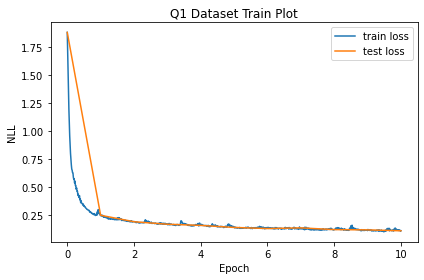

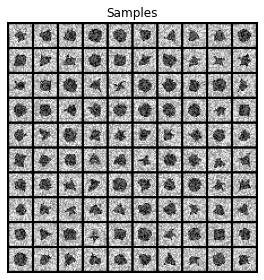

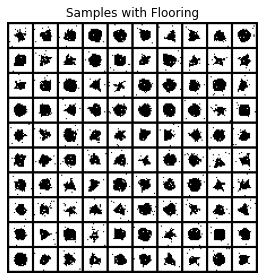

In [106]:
q1_save_results(q1)